In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **트랜스포머**




In [ ]:
import tensorflow as tf
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.dense = tf.keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 첫번째 서브층 : 멀티 헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm
        ffn_output = self.ffn(out1) # 두번째 서브층 : 포지션 와이즈 피드 포워드 신경망
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
vocab_size = 20000  # 빈도수 상위 2만개의 단어만 사용
max_len = 200  # 문장의 최대 길이

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)
print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)
embedding_dim = 32  # 각 단어의 임베딩 벡터의 차원
num_heads = 2  # 어텐션 헤드의 수
dff = 32  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기

inputs = tf.keras.layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
x = transformer_block(x, training=True)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=32, epochs=2, validation_data=(X_test, y_test))

print("테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: IMDB 데이터셋의 Word Index 로드
word_index = tf.keras.datasets.imdb.get_word_index()

# Step 2: Word Index에 없는 단어를 처리하기 위해 +3 오프셋을 적용 (IMDB 데이터셋의 특수 토큰 때문)
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

# Step 3: 문장을 Word Index를 기반으로 토큰화하는 함수
def tokenize_sentence(sentence, word_index):
    tokens = [word_index.get(word.lower(), word_index["<UNK>"]) for word in sentence.split()]
    return [word_index["<START>"]] + tokens

# Step 4: 새로운 문장 토큰화 및 패딩
new_sentences = [
    "This movie was fantastic and I loved it",
    "I hated this movie. It was terrible"
]

new_sequences = [tokenize_sentence(sentence, word_index) for sentence in new_sentences]
new_sequences_padded = pad_sequences(new_sequences, maxlen=max_len, padding='post')

# Step 5: 예측 수행
predictions = model.predict(new_sequences_padded)

# Step 6: 결과 출력
print("Predictions (probabilities):", predictions)

predicted_classes = tf.argmax(predictions, axis=-1).numpy()
print("Predicted Classes (0: 부정, 1: 긍정):", predicted_classes)


# **나이브 베이즈 모델**

In [ ]:
!pip install konlpy
!apt-get update
!apt-get install -y openjdk-11-jdk

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += os.pathsep + "/usr/lib/jvm/java-11-openjdk-amd64/bin"

from konlpy.tag import Okt
okt = Okt()
print(okt.morphs("설치 완료 후 형태소 분석을 테스트합니다."))

In [ ]:
import nltk

# punkt 및 관련 데이터 재설치
nltk.download('punkt')
nltk.download('punkt_tab')  # 오류에서 명시한 추가 리소스 다운로드

In [ ]:
from sklearn.datasets import load_files
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import pickle
import re
import konlpy
import nltk
import numpy as np

def clean_korean_documents(documents):
    #텍스트 정제 (HTML 태그 제거)
    for i, document in enumerate(documents):
        document = BeautifulSoup(document, 'html.parser').text
        documents[i] = document

    #텍스트 정제 (특수기호 제거)
    for i, document in enumerate(documents):
        document = re.sub(r'[^ ㄱ-ㅣ가-힣]', '', document) #특수기호 제거, 정규 표현식
        documents[i] = document

    #텍스트 정제 (형태소 분석)
    for i, document in enumerate(documents):
        okt = konlpy.tag.Okt()
        clean_words = []
        for word in okt.pos(document, stem=True): #어간 추출
            if word[1] in ['Noun', 'Verb', 'Adjective']: #명사, 동사, 형용사
                clean_words.append(word[0])
        document = ' '.join(clean_words)
        documents[i] = document

    #텍스트 정제 (불용어 제거)
    df = pd.read_csv('https://raw.githubusercontent.com/cranberryai/todak_todak_python/master/machine_learning_text/clean_korean_documents/korean_stopwords.txt', header=None)
    df[0] = df[0].apply(lambda x: x.strip())
    stopwords = df[0].to_numpy()
    nltk.download('punkt')
    for i, document in enumerate(documents):
        clean_words = []
        for word in nltk.tokenize.word_tokenize(document):
            if word not in stopwords: #불용어 제거
                clean_words.append(word)
        documents[i] = ' '.join(clean_words)

    return documents

##########데이터 로드

naver_news = load_files('/content/drive/MyDrive/프로젝트/newsData', shuffle=True)

labels = ['정치', '경제', '사회', '생활/문화', '세계', '기술/IT', '연예', '스포츠']

##########데이터 분석

##########데이터 전처리

x_data = naver_news.data
y_data = naver_news.target
# x_data = x_data[:50] #데이터를 50개로 제한
# y_data = y_data[:50]

# print(x_data[0]) #b'\xed\x83\x9c\xec\x96\x91\xea\xb4\x91\xec\x9c\xbc\xeb\xa1\x9c \xec\xb6\xa9\xec\xa0\x84\xeb\x90\x98\xeb\x8a\x94 \xe2\x80\x98\xec\x95\x84\xec\x9d\xb4\xed\x8f\xb0X ...'
# print(y_data[0]) #5

x_data = [x.decode('utf-8') for x in x_data] #바이트를 문자열로 바꾸기
# print(x_data[0]) #태양광으로 충전되는 ‘아이폰X 테슬라’ (지디넷코리아=이정현 기자)도널드 트럼프 미국 대통령과 푸틴 러시아 대통령의 초상화를 새긴 황금 아이폰을 출시해 ...

x_data = clean_korean_documents(x_data) #텍스트 정제
transformer = TfidfVectorizer()
transformer.fit(x_data)
x_data = transformer.transform(x_data) #단어 카운트 가중치

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=777, stratify=y_data)

##########모델 생성

model = MultinomialNB(alpha=1.0)

##########모델 학습

history = model.fit(x_train, y_train)

##########모델 검증

print('테스트 점수: ', model.score(x_test, y_test)) #1.0

##########모델 예측

x_test = np.array([
"""감사원 "감사원장 탄핵 시도는 헌법정신 위반…중지 촉구"

더불어민주당의 최재해 감사원장 탄핵 추진에 대해 감사원이 "헌법 정신을 위반하는 부당한 압박"이라고 비판했습니다.

감사원은 어제(28일) 입장문에서 "감사원장 탄핵은 감사원의 헌법상 기능을 마비시키는 것으로 국민들에게 심대한 피해를 끼치게 될 것"이라고 밝혔습니다.

이어 "최 원장이 취임한 뒤 국가통계 조작과 서해공무원 피살 사건 등 국기문란 사건을 철저하게 감사했다"고 강조하며 "민주당이 주장하는 탄핵 사유는 전혀 근거가 없다"고 반박했습니다.

그러면서 "지금이라도 위헌·위법적인 감사원장 탄핵 시도를 중지할 것을 강력히 촉구한다"고 덧붙였습니다.
"""

])
x_test = clean_korean_documents(x_test) #텍스트 정제
x_test = transformer.transform(x_test) #단어 카운트 가중치

y_predict = model.predict(x_test)
label = labels[y_predict[0]]
y_predict = model.predict_proba(x_test)
confidence = y_predict[0][y_predict[0].argmax()]

print(label, confidence)

# **네이버 뉴스 기사 데이터 받아오기**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
import os
from concurrent.futures import ThreadPoolExecutor
import numpy as np

# 결과를 저장할 1차원 배열
news_data_list = []

# 디렉토리와 파일 이름 설정
base_path = '/content/drive/MyDrive/newsData'

def process_file(file_info):
    """파일 읽기 작업을 처리하는 함수"""
    dir_index, file_index = file_info
    dir_path = os.path.join(base_path, str(dir_index))
    file_name = f"{dir_index}{str(file_index).zfill(3)}NewsData.txt"
    file_path = os.path.join(dir_path, file_name)

    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    return None

# 파일 작업 준비
file_indices = [(i, j) for i in range(8) for j in range(200)]

# 멀티스레딩 사용
with ThreadPoolExecutor() as executor:
    results = list(executor.map(process_file, file_indices))

# 결과 필터링 (None 제거)
news_data_list = [content for content in results if content]

# 결과 출력
print(len(news_data_list))  # 파일 개수 확인

# target 생성
target = []
for i in range(8):
    target += ([i] * 200)
print(np.shape(target))


1600
(1600,)


# **배치 사이즈와 에포크 관계 파악**

In [ ]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer


# Load KLUE-BERT model and tokenizer
model_name = "klue/bert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertModel.from_pretrained(model_name)

# Define input length
max_len = 256  # Reduce max_len to avoid OOM errors

# CLS 토큰 계산
def compute_cls(sentences, tokenizer, bert_model, max_len):
    inputs = tokenizer(
        sentences,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # BERT 모델로 CLS 토큰 추출
    outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    cls_token = outputs.last_hidden_state[:, 0, :]  # CLS 토큰
    # print(cls_token.shape)

    return cls_token.numpy().squeeze()

cls_tokens = np.array([compute_cls(sentence, tokenizer, bert_model, max_len) for sentence in news_data_list])
print(np.shape(cls_tokens))




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'bert.embeddings.position_ids', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already u

(1600, 768)


In [ ]:
# Define data preprocessing function
def preprocess_data(sentences, labels, tokenizer, max_len):
    inputs = tokenizer(
        sentences,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    return input_ids, attention_mask, tf.convert_to_tensor(labels)

# 데이터를 학습용과 테스트용으로 분리
X_train, X_test, y_train, y_test = train_test_split(cls_tokens, target, test_size=0.2, random_state=42)
# numpy 배열을 tf.Tensor로 변환
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

In [ ]:
from tensorflow.keras.layers import BatchNormalization

In [ ]:
# Batch Size와 Epoch 설정
batch_sizes = [16, 32, 64, 128, 256]
learning_rate_list=[1e-5, 1e-4, 1e-3, 5e-3, 8e-3]


# 결과 기록
results = []

# 여러 Batch Size와 Epoch 조합 실행
for batch_size, learning_rate in zip(batch_sizes, learning_rate_list):
        print(f"Running with Batch Size: {batch_size}, Learning Rate: {learning_rate}")

        # 새롭게 정의된 입력에 따라 모델 구성
        input_layer = tf.keras.Input(shape=(cls_tokens.shape[1],), dtype=tf.float32, name="cls_input")
        x = tf.keras.layers.Dense(512, activation="relu")(input_layer)
        x = BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        output_layer = tf.keras.layers.Dense(8, activation="softmax")(x)

        # 모델 정의
        model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

        # 모델 컴파일
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        # EarlyStopping 콜백
        early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

        # 모델 학습
        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_test, y_test),
            batch_size=batch_size,
            epochs=10,
            callbacks=[early_stopping_cb],
        )

        # 평가
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Accuracy: {test_acc:.4f}")




Running with Batch Size: 16, Learning Rate: 1e-05
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1325 - loss: 2.8987 - val_accuracy: 0.1969 - val_loss: 2.2104
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2014 - loss: 2.4773 - val_accuracy: 0.2750 - val_loss: 1.9473
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2614 - loss: 2.1823 - val_accuracy: 0.3344 - val_loss: 1.7791
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3232 - loss: 2.0551 - val_accuracy: 0.4062 - val_loss: 1.6474
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3657 - loss: 1.9066 - val_accuracy: 0.4563 - val_loss: 1.5459
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4297 - loss: 1.6129 - val_accuracy: 0.4938 - val_loss: 1.4608
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4320 - loss: 1.5990 - val_accuracy: 0.5125 - val_loss: 1.3892
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.490

In [ ]:
# Batch Size와 Epoch 설정
batch_sizes = [16, 32, 64, 128, 256]
learning_rate_list=[5e-5, 8e-5, 1e-4, 5e-4, 1e-3]


# 결과 기록
results = []

# 여러 Batch Size와 Epoch 조합 실행
for batch_size, learning_rate in zip(batch_sizes, learning_rate_list):
        print(f"Running with Batch Size: {batch_size}, Learning Rate: {learning_rate}")

        # 새롭게 정의된 입력에 따라 모델 구성
        input_layer = tf.keras.Input(shape=(cls_tokens.shape[1],), dtype=tf.float32, name="cls_input")
        x = tf.keras.layers.Dense(512, activation="relu")(input_layer)
        x = BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        output_layer = tf.keras.layers.Dense(8, activation="softmax")(x)

        # 모델 정의
        model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

        # 모델 컴파일
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )


        # 모델 학습
        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_test, y_test),
            batch_size=batch_size,
            epochs=10
        )

        # 평가
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Accuracy: {test_acc:.4f}")




Running with Batch Size: 16, Learning Rate: 5e-05
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.1789 - loss: 2.6229 - val_accuracy: 0.4469 - val_loss: 1.6325
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4734 - loss: 1.5158 - val_accuracy: 0.6125 - val_loss: 1.2165
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5584 - loss: 1.2092 - val_accuracy: 0.6781 - val_loss: 0.9924
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6844 - loss: 0.9383 - val_accuracy: 0.7125 - val_loss: 0.8793
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7441 - loss: 0.7436 - val_accuracy: 0.7344 - val_loss: 0.8111
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7837 - loss: 0.6577 - val_accuracy: 0.7375 - val_loss: 0.7768
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7960 - loss: 0.5769 - val_accuracy: 0.7500 - val_loss: 0.7532
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.838

In [ ]:
# Batch Size와 Epoch 설정
batch_sizes = [16, 32, 64, 128, 256]
learning_rate_list=[1e-6, 5e-6, 1e-5, 5e-5, 1e-4]


# 결과 기록
results = []

# 여러 Batch Size와 Epoch 조합 실행
for batch_size, learning_rate in zip(batch_sizes, learning_rate_list):
        print(f"Running with Batch Size: {batch_size}, Learning Rate: {learning_rate}")

        # 새롭게 정의된 입력에 따라 모델 구성
        input_layer = tf.keras.Input(shape=(cls_tokens.shape[1],), dtype=tf.float32, name="cls_input")
        x = tf.keras.layers.Dense(512, activation="relu")(input_layer)
        x = BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        output_layer = tf.keras.layers.Dense(8, activation="softmax")(x)

        # 모델 정의
        model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

        # 모델 컴파일
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )



        # 모델 학습
        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_test, y_test),
            batch_size=batch_size,
            epochs=10
        )

        # 평가
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Accuracy: {test_acc:.4f}")




Running with Batch Size: 16, Learning Rate: 1e-06
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1050 - loss: 3.1741 - val_accuracy: 0.1312 - val_loss: 2.5104
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1049 - loss: 3.0421 - val_accuracy: 0.1281 - val_loss: 2.5547
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1215 - loss: 3.1115 - val_accuracy: 0.1094 - val_loss: 2.6294
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1211 - loss: 2.9749 - val_accuracy: 0.1219 - val_loss: 2.6962
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1103 - loss: 3.0175 - val_accuracy: 0.1250 - val_loss: 2.7414
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1458 - loss: 2.9859 - val_accuracy: 0.1437 - val_loss: 2.7653
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1404 - loss: 2.8933 - val_accuracy: 0.1437 - val_loss: 2.7716
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.137

# **BERT 모델**

배치 사이즈: 15, 에포크 10

In [ ]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
# 위에서 import 과정을 했기 때문에 없어도 됨

In [ ]:
# BERT 파인 튜닝
# Load KLUE-BERT model and tokenizer
model_name = "klue/bert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertModel.from_pretrained(model_name)

# Define input length
max_len = 256  # Reduce max_len to avoid OOM errors

# Define Keras input layers
input_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

# Wrap BERT model into a Keras layer
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model):
        super(BertLayer, self).__init__()
        self.bert_model = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        cls_tokens = outputs.last_hidden_state[:, 0, :]      # CLS token output
        print(np.shape(cls_tokens))
        return cls_tokens

# Add BERT model as a layer
bert_output = BertLayer(bert_model)((input_ids, attention_mask))

# Add a classifier
x = tf.keras.layers.Dense(512, activation="relu")(bert_output)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(8, activation="softmax")(x)

# Define the complete model
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=7e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Print model summary
model.summary()

# Define data preprocessing function
def preprocess_data(sentences, labels, tokenizer, max_len):
    inputs = tokenizer(
        sentences,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    return input_ids, attention_mask, tf.convert_to_tensor(labels)

# Preprocess the data
input_ids, attention_mask, y = preprocess_data(news_data_list, target, tokenizer, max_len)
X = {'input_ids': input_ids, 'attention_mask': attention_mask}

# Split data into train and test sets
X_train_ids, X_test_ids, y_train, y_test = train_test_split(
    X['input_ids'].numpy(), y.numpy(), shuffle=True, test_size=0.2, random_state=42
)
X_train_mask, X_test_mask, _, _ = train_test_split(
    X['attention_mask'].numpy(), y.numpy(), shuffle=True, test_size=0.2, random_state=42
)

# Train the model
history = model.fit(
    {"input_ids": X_train_ids, "attention_mask": X_train_mask},
    y_train,
    validation_data=({"input_ids": X_test_ids, "attention_mask": X_test_mask}, y_test),
    batch_size=15,  # Reduce batch size to prevent OOM
    epochs=10
)

# Evaluate the model
test_loss, test_acc = model.evaluate(
    {"input_ids": X_test_ids, "attention_mask": X_test_mask},
    y_test
)
print(f"Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'bert.embeddings.position_ids', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another ta

(None, 768)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 bert_layer (BertLayer)      (None, 768)                  1106173   ['input_ids[0][0]',           
                                                          44         'attention_mask[0][0]']      
                                                                                  

(None, 768)


86/86 [==============================] - 129s 966ms/step - loss: 0.8619 - accuracy: 0.7211 - val_loss: 0.5178 - val_accuracy: 0.8531
Epoch 2/10
86/86 [==============================] - 76s 887ms/step - loss: 0.3056 - accuracy: 0.9125 - val_loss: 0.3804 - val_accuracy: 0.8938
Epoch 3/10
86/86 [==============================] - 80s 934ms/step - loss: 0.1741 - accuracy: 0.9367 - val_loss: 0.4345 - val_accuracy: 0.8719
Epoch 4/10
86/86 [==============================] - 80s 936ms/step - loss: 0.0719 - accuracy: 0.9773 - val_loss: 0.5970 - val_accuracy: 0.8750
Epoch 5/10
86/86 [==============================] - 76s 886ms/step - loss: 0.0675 - accuracy: 0.9797 - val_loss: 0.5436 - val_accuracy: 0.8781
Epoch 6/10
86/86 [==============================] - 80s 935ms/step - loss: 0.0227 - accuracy: 0.9930 - val_loss: 0.5795 - val_accuracy: 0.8844
Epoch 7/10
86/86 [==============================] - 81s 937ms/step - loss: 0.0083 - accuracy: 0.9984 - val_loss: 0.6036 - val_accuracy: 0.9156
Epoch 8/1

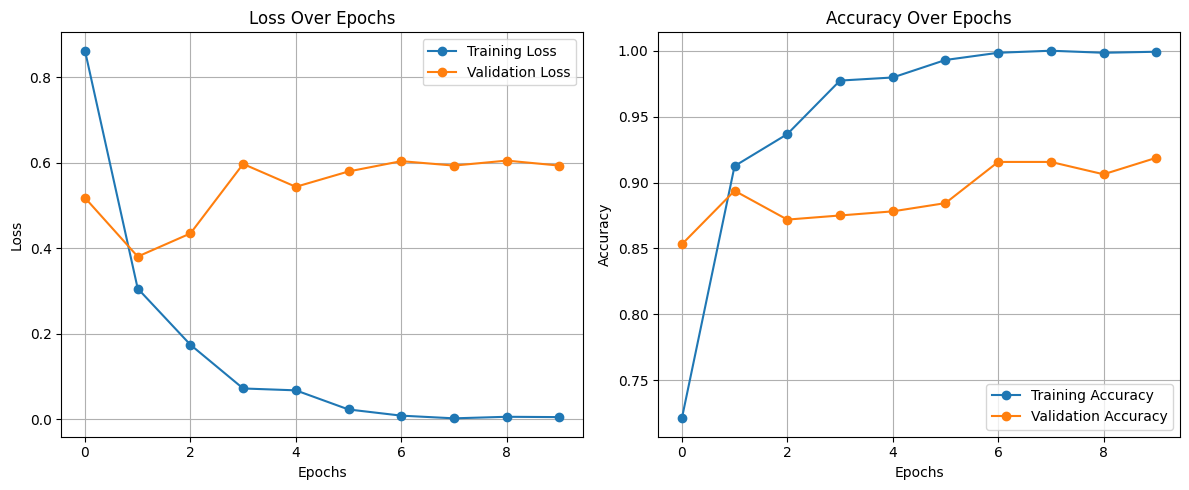

In [ ]:
import matplotlib.pyplot as plt

# history 객체에서 훈련과 검증의 손실 및 정확도 추출
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 1. 손실 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 2. 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# **BERT 토크나이저 활용한 신경망 학습(1번째 시도)**

# **배치: 75, 에포크: 40**

In [ ]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer

# Load KLUE-BERT model and tokenizer
model_name = "klue/bert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertModel.from_pretrained(model_name)

# Define input length
max_len = 256  # Reduce max_len to avoid OOM errors

# CLS 토큰 계산
def compute_cls(sentences, tokenizer, bert_model, max_len):
    inputs = tokenizer(
        sentences,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # BERT 모델로 CLS 토큰 추출
    outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    cls_token = outputs.last_hidden_state[:, 0, :]  # CLS 토큰
    # print(cls_token.shape)

    return cls_token.numpy().squeeze()

cls_tokens = np.array([compute_cls(sentence, tokenizer, bert_model, max_len) for sentence in news_data_list])
print(np.shape(cls_tokens))




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'bert.embeddings.position_ids', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already u

(1600, 768)


In [ ]:
# Define data preprocessing function
def preprocess_data(sentences, labels, tokenizer, max_len):
    inputs = tokenizer(
        sentences,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    return input_ids, attention_mask, tf.convert_to_tensor(labels)

# 데이터를 학습용과 테스트용으로 분리
X_train, X_test, y_train, y_test = train_test_split(cls_tokens, target, test_size=0.2, random_state=42)
# numpy 배열을 tf.Tensor로 변환
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

In [ ]:
# Add a classifier
input_layer = tf.keras.Input(shape=(cls_tokens.shape[1],), dtype=tf.float32, name="cls_input")
x = tf.keras.layers.Dense(2000, activation="relu")(input_layer)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1000, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(8, activation="softmax")(x)

# Define the complete model
model = tf.keras.Model(inputs=input_layer, outputs=outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Print model summary
model.summary()

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=75,  # Reduce batch size to prevent OOM
    epochs=40
)

# Evaluate the model
test_loss, test_acc = model.evaluate(
    X_test,
    y_test
)
print(f"Test Accuracy: {test_acc:.4f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cls_input (InputLayer)      [(None, 768)]             0         
                                                                 
 dense (Dense)               (None, 2000)              1538000   
                                                                 
 dropout_37 (Dropout)        (None, 2000)              0         
                                                                 
 dense_1 (Dense)             (None, 1000)              2001000   
                                                                 
 dropout_38 (Dropout)        (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 8)                 8008      
                                                                 
Total params: 3547008 (13.53 MB)
Trainable params: 3547008 (1

In [ ]:
new_sentences = [
    "감사원 '감사원장 탄핵 시도는 헌법정신 위반…중지 촉구'",
    "더불어민주당의 최재해 감사원장 탄핵 추진에 대해 감사원이 '헌법 정신을 위반하는 부당한 압박'이라고 비판했습니다.",
    "감사원은 어제(28일) 입장문에서 '감사원장 탄핵은 감사원의 헌법상 기능을 마비시키는 것으로 국민들에게 심대한 피해를 끼치게 될 것'이라고 밝혔습니다.",
    "이어 '최 원장이 취임한 뒤 국가통계 조작과 서해공무원 피살 사건 등 국기문란 사건을 철저하게 감사했다'고 강조하며 '민주당이 주장하는 탄핵 사유는 전혀 근거가 없다'고 반박했습니다.",
    "그러면서 '지금이라도 위헌·위법적인 감사원장 탄핵 시도를 중지할 것을 강력히 촉구한다'고 덧붙였습니다."
]

labels = ['정치', '경제', '사회', '생활/문화', '세계', '기술/IT', '연예', '스포츠']

# [-1]은 여기선 사용하지 않음
new_token = compute_cls(new_sentences, tokenizer, bert_model, max_len)
X_new = tf.convert_to_tensor(new_token, dtype=tf.float32)

predictions = model.predict(X_new)
predicted_classes = tf.argmax(predictions, axis=1).numpy()

# Access the first element of predicted_classes to get the predicted class index
predicted_class_index = predicted_classes[0]
print("Predicted classes:", labels[predicted_class_index])

1/1 [==============================] - 0s 70ms/step
Predicted classes: 정치


# **배치 사이즈: 75, 에포크 25**

In [ ]:
# Add a classifier
input_layer = tf.keras.Input(shape=(cls_tokens.shape[1],), dtype=tf.float32, name="cls_input")
x = tf.keras.layers.Dense(2000, activation="relu")(input_layer)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1000, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(8, activation="softmax")(x)

# Define the complete model
model = tf.keras.Model(inputs=input_layer, outputs=outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Print model summary
model.summary()

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=75,  # Reduce batch size to prevent OOM
    epochs=25
)

# Evaluate the model
test_loss, test_acc = model.evaluate(
    X_test,
    y_test
)
print(f"Test Accuracy: {test_acc:.4f}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cls_input (InputLayer)      [(None, 768)]             0         
                                                                 
 dense_3 (Dense)             (None, 2000)              1538000   
                                                                 
 dropout_39 (Dropout)        (None, 2000)              0         
                                                                 
 dense_4 (Dense)             (None, 1000)              2001000   
                                                                 
 dropout_40 (Dropout)        (None, 1000)              0         
                                                                 
 dense_5 (Dense)             (None, 8)                 8008      
                                                                 
Total params: 3547008 (13.53 MB)
Trainable params: 3547008 

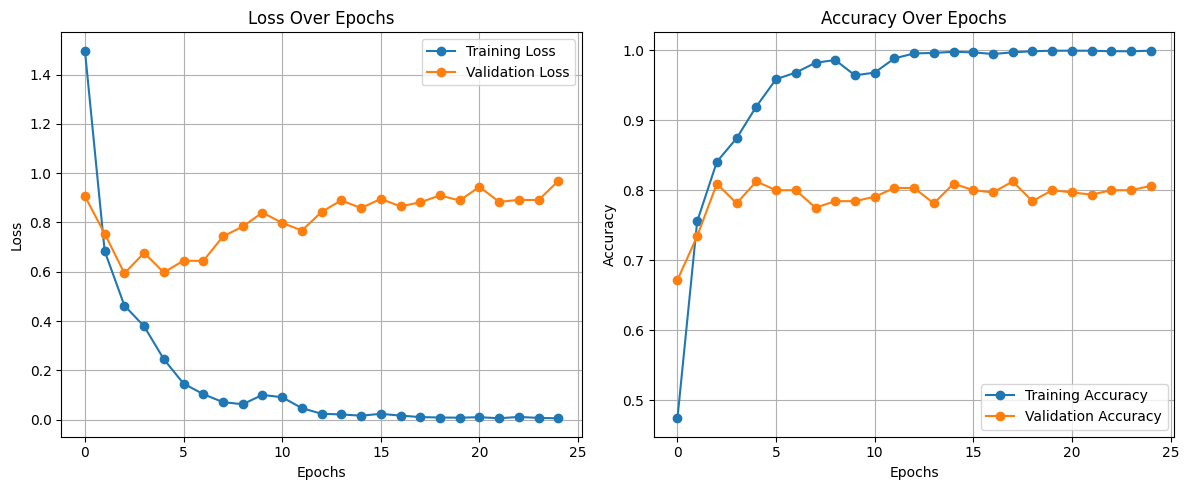

In [ ]:
import matplotlib.pyplot as plt

# history 객체에서 훈련과 검증의 손실 및 정확도 추출
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 1. 손실 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 2. 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# **신경망 모델(2번째 시도)**
여러 문장 처리를 위한 CLS 토큰 평균 연산 적용

In [ ]:
#뉴스데이터리스트의 각각의 문단들을 문장들로 나뉘어진 리스트 하나로 변경
def divide_sentences(sentences_list):
  i = 0
  data = []
  for sentences in sentences_list:

    sentences = sentences.split(".")
    data.append(sentences)
    i += 1
    if(i%100 == 0):
      print(i)
  return data

div_news_data_list = divide_sentences(news_data_list)
print(div_news_data_list[0])

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
["동남아 담당' 北 최희철 부상 베이징 도착…싱가포르행 주목\t최 부상, 행선지·방문 목적 질문에는 '묵묵부답'\n\n(베이징=연합뉴스) 김진방 특파원 = 북한이 북미 정상회담 무산 가능성까지 거론하며 강경한 태도를 보이는 가운데 동남아시아 외교를 담당하는 최희철 북한 외무성 부상이 19일 중국 베이징 서우두(首都) 공항에 모습을 드러냈다", '\n\n최 부상은 이날 오전 평양발 고려항공 JS151편을 이용해 베이징 서우두 공항에 도착했다', '\n\n최 부상은 최종 목적지를 묻는 취재진의 질문에 아무런 답변을 하지 않고, 북한 대사관 관계자들과 함께 공항을 빠져나갔다', '\n\n북미 정상회담을 20여 일 앞둔 상황에서 동남아 외교통인 최 부상이 정상회담 준비 등을 위해 회담 개최 예정지인 싱가포르를 방문할 가능성도 제기되고 있다', '\n\n최 부상은 지난 3월에도 아세안(ASEAN·동남아시아국가연합) 의장국이기도 한 싱가포르를 방문해 양국관계와 올해 8월 열리는 아세안지역안보포럼(ARF) 의제 등을 논의한 바 있다', '\n\n또 지난해 북핵 문제를 두고 북미 간 긴장관계가 형성됐을 때도 ARF에 참석해 아세안을 상대로 여론전을 펼쳤다', ' 북한의 초청으로 비자이 쿠마르 싱 인도 외교부 국무장관이 방북했을 때도 최 부상은 싱 국무장관을 직접 영접하고, 한반도 문제를 논의하기도 했다', '\n\n베이징 소식통은 "최 부상이 대(對)미 외교담당이 아니기 때문에 싱가포르로 갈 가능성이 큰 것은 아니다"며 "만약 싱가포르에 간다면 정상회담과 관련한 지원 작업 준비 등을 위한 것일 가능성이 크다"고 말했다', '']


# **배치 사이즈: 15, 에포크 20**

In [ ]:
import numpy as np
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization

# Load KLUE-BERT model and tokenizer
model_name = "klue/bert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertModel.from_pretrained(model_name)

# Define input length
max_len = 256  # Reduce max_len to avoid OOM errors

# CLS 토큰 평균값 계산 함수 추가
def compute_cls_mean(sentences, tokenizer, bert_model, max_len):
    inputs = tokenizer(
        sentences,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # BERT 모델로 CLS 토큰 추출
    outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    cls_tokens = outputs.last_hidden_state[:, 0, :]  # CLS 토큰

    # CLS 토큰 평균값 계산
    cls_mean = tf.reduce_mean(cls_tokens, axis=0)
    return cls_mean.numpy()  # Numpy 배열로 변환


# 데이터 전처리 및 CLS 평균값 계산
cls_means = []
for sentences in div_news_data_list:
    cls_mean = compute_cls_mean(sentences, tokenizer, bert_model, max_len)
    cls_means.append(cls_mean)

# 평균값을 새로운 입력 데이터로 변환
cls_means = np.array(cls_means)

# 데이터를 학습용과 테스트용으로 분리
X_train, X_test, y_train, y_test = train_test_split(cls_means, target, test_size=0.2, random_state=42)
# numpy 배열을 tf.Tensor로 변환
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already u

In [ ]:
# 새롭게 정의된 입력에 따라 모델 수정
input_layer = tf.keras.Input(shape=(cls_means.shape[1],), dtype=tf.float32, name="cls_mean_input")
x = tf.keras.layers.Dense(2000, activation="relu")(input_layer)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1000, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)

output_layer = tf.keras.layers.Dense(8, activation="softmax")(x)

# 모델 재정의
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 학습
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=15,
    epochs=20
)

# 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.3698 - loss: 1.7771 - val_accuracy: 0.8344 - val_loss: 0.7448
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7844 - loss: 0.7585 - val_accuracy: 0.8594 - val_loss: 0.5022
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8087 - loss: 0.5897 - val_accuracy: 0.8562 - val_loss: 0.4385
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8364 - loss: 0.4787 - val_accuracy: 0.8656 - val_loss: 0.4441
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8742 - loss: 0.3892 - val_accuracy: 0.8719 - val_loss: 0.3947
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8876 - loss: 0.3496 - val_accuracy: 0.8906 - val_loss: 0.3909
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9030 - loss: 0.2947 - val_accuracy: 0.8687 - val_loss: 0.4077
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9000 - loss: 0.3068 - val_accuracy: 0.8906 - val_loss

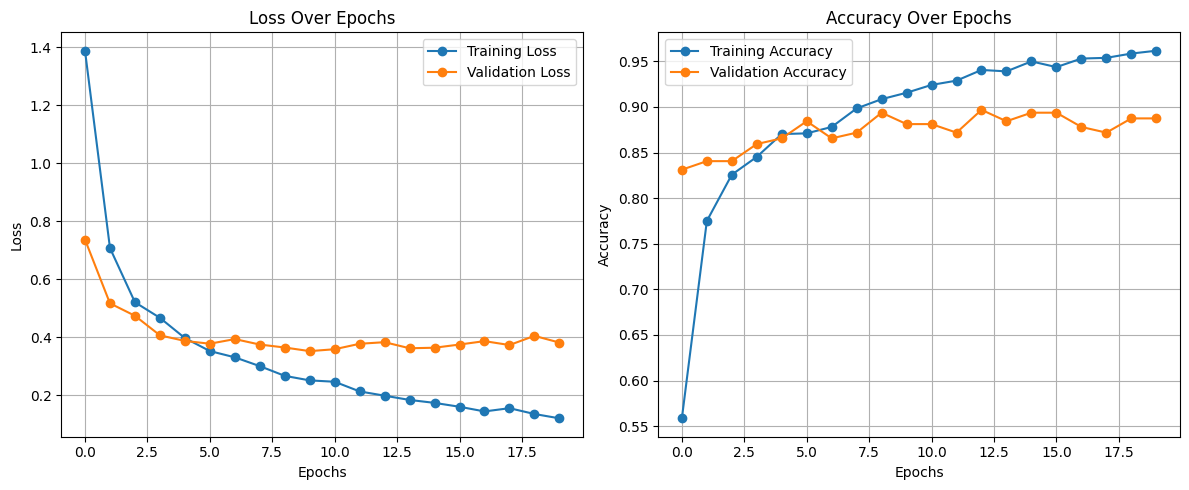

In [ ]:
import matplotlib.pyplot as plt

# history 객체에서 훈련과 검증의 손실 및 정확도 추출
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 1. 손실 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 2. 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# **배치 사이즈: 15, 에포크: 7**

In [ ]:
# 새롭게 정의된 입력에 따라 모델 수정
input_layer = tf.keras.Input(shape=(cls_means.shape[1],), dtype=tf.float32, name="cls_mean_input")
x = tf.keras.layers.Dense(2000, activation="relu")(input_layer)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1000, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)

output_layer = tf.keras.layers.Dense(8, activation="softmax")(x)

# 모델 재정의
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 학습
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=15,
    epochs=7
)

# 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/7
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.2656 - loss: 1.9382 - val_accuracy: 0.7188 - val_loss: 1.1586
Epoch 2/7
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6543 - loss: 1.0963 - val_accuracy: 0.7437 - val_loss: 0.8041
Epoch 3/7
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7725 - loss: 0.7488 - val_accuracy: 0.7656 - val_loss: 0.6852
Epoch 4/7
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8348 - loss: 0.5445 - val_accuracy: 0.7906 - val_loss: 0.6366
Epoch 5/7
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8439 - loss: 0.4984 - val_accuracy: 0.7906 - val_loss: 0.6229
Epoch 6/7
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8941 - loss: 0.3878 - val_accuracy: 0.8000 - val_loss: 0.5797
Epoch 7/7
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9050 - loss: 0.3129 - val_accuracy: 0.8031 - val_loss: 0.5788
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8069 - loss: 0.6004  
Test Accuracy: 0.8031


In [ ]:
# 입력 텍스트를 BERT 토큰화 및 예측
def predict_category():
    input_text = input()
    input_texts = input_text.split(".")

    # 토큰화
    inputs = tokenizer(
        input_texts,
        max_length=256,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # BERT 모델로 CLS 토큰 추출
    bert_model = TFBertModel.from_pretrained("klue/bert-base")
    outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    cls_tokens = outputs.last_hidden_state[:, 0, :]  # 각 문장의 CLS 토큰 추출
    print(np.shape(cls_tokens))

    # CLS 토큰들의 평균 계산
    cls_mean = tf.reduce_mean(cls_tokens, axis=0, keepdims=True)

    # 모델로 예측
    prediction = model.predict(cls_mean)
    predicted_label = tf.argmax(prediction, axis=1).numpy()[0]

    label_list = ["정치", "경제", "사회", "생활/문화", "세계", "기술/IT", "연예", "스포츠"]

    # 결과 출력
    print(f"예측 결과: {max(prediction[0])*100:.2f}% 확률로 '{label_list[predicted_label]}' 분야입니다.")


In [ ]:
predict_category()

김치.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'bert.embeddings.position_ids', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already u

(2, 768)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
예측 결과: 38.59% 확률로 '스포츠' 분야입니다.


# **신경망 모델 LSTM 적용(3번째 시도)**

In [ ]:
def check(num):
  print(len(div_news_data_list[num]))
  print(target[num])
check(1599)

16
7


# **모델 1**

In [ ]:
import numpy as np
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional

# Load KLUE-BERT model and tokenizer
model_name = "klue/bert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertModel.from_pretrained(model_name)

# Define input length
max_len = 256  # Max sequence length for each sentence

# CLS 토큰 계산 함수
def compute_sentence_cls_tokens(article_sentences, tokenizer, bert_model, max_len):

    cls_tokens = []

    inputs = tokenizer(
        article_sentences,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    cls_token = outputs.last_hidden_state[:, 0, :]  # CLS 토큰
    cls_tokens.append(cls_token.numpy())

    return np.vstack(cls_tokens)


articles_cls_tokens = []
i = 0
for article in div_news_data_list:
    cls_tokens = compute_sentence_cls_tokens(article, tokenizer, bert_model, max_len)
    articles_cls_tokens.append(cls_tokens)
    i += 1
    if i % 100 == 0:
        print(f"Processed {i} articles")

# 각 기사의 CLS 토큰 리스트를 패딩 처리
max_sentences = max(len(article) for article in articles_cls_tokens)
embedding_dim = articles_cls_tokens[0].shape[1]

# 패딩 처리하여 동일한 문장 개수로 맞춤
padded_cls_tokens = []
for article in articles_cls_tokens:
    pad_length = max_sentences - len(article)
    padded_article = np.pad(article, ((0, pad_length), (0, 0)), mode="constant")
    padded_cls_tokens.append(padded_article)




Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'bert.embeddings.position_ids', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already u

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(9, 256, 768), dtype=float32, numpy=
array([[[ 0.20260297, -0.2803205 ,  0.30203205, ..., -0.03096258,
         -0.97755986, -0.34465125],
        [-0.4191573 ,  0.40956587, -0.0840783 , ..., -0.29383644,
          0.02742152, -0.82548815],
        [ 0.8020953 , -1.2008989 , -0.05177408, ...,  1.2049392 ,
          0.43628013, -0.837214  ],
        ...,
        [-0.07003278, -1.6625092 ,  0.2812697 , ..., -0.23368044,
         -1.7596538 ,  0.6591511 ],
        [-0.27148846, -1.0179453 ,  0.14229795, ..., -0.14961526,
         -1.3440465 ,  0.25778872],
        [-0.6135872 , -0.98826605, -0.55527973, ..., -0.29035008,
          0.15557835,  0.09719467]],

       [[-0.23350501, -1.2275354 ,  0.46043634, ...,  0.0935394 ,
         -1.7485632 ,  0.44853717],
        [-0.7484848 , -1.658767  ,  0.4553526 , ..., -0.8531151 ,
         -1.4681809 ,  0.9735848 ],
        [-0.5233993 , -0.22509563,  0.5384808 , .

KeyboardInterrupt: 

In [ ]:
padded_cls_tokens = np.array(padded_cls_tokens)  # [num_articles, max_sentences, embedding_dim]

# 데이터를 학습용과 테스트용으로 분리
X_train, X_test, y_train, y_test = train_test_split(padded_cls_tokens, target, test_size=0.2, random_state=42)

# 텐서 변환
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

# 원-핫 인코딩 (카테고리 수: 8)
num_classes = len(set(target))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# 모델 정의
def build_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape, name="input_layer")

    # Bidirectional LSTM
    lstm_out = Bidirectional(LSTM(128, return_sequences=False))(inputs)

    # Fully Connected Layer
    outputs = Dense(num_classes, activation="softmax", name="output_layer")(lstm_out)

    model = Model(inputs=inputs, outputs=outputs, name="LSTM_Classifier")
    return model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 모델 생성
input_shape = (max_sentences, embedding_dim)
model = build_lstm_model(input_shape, num_classes)

# 학습률 설정
learning_rate = 5e-3  # 원하는 학습률 값
optimizer = Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# EarlyStopping 설정
early_stopping = EarlyStopping(
    monitor="val_loss",  # 검증 손실 기준
    patience=2,          # 성능이 개선되지 않는 에포크 수 (5번 기다림)
    restore_best_weights=True  # 가장 성능이 좋았던 모델의 가중치를 복원
)

# 모델 요약
model.summary()

# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=60,
    batch_size=500,
    callbacks=[early_stopping]  # EarlyStopping 콜백 추가
)

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 88, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         918,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 920,584 (3.51 MB)

 Trainable params: 920,584 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 299ms/step - accuracy: 0.1955 - loss: 2.0720 - val_accuracy: 0.6250 - val_loss: 1.3598
Epoch 2/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.6573 - loss: 1.2372 - val_accuracy: 0.7344 - val_loss: 0.9463
Epoch 3/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.7862 - loss: 0.8556 - val_accuracy: 0.5234 - val_loss: 1.3806
Epoch 4/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6227 - loss: 1.0549 - val_accuracy: 0.7578 - val_loss: 0.8094
Epoch 5/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.7791 - loss: 0.6635 - val_accuracy: 0.7656 - val_loss: 0.6950
Epoch 6/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8095 - loss: 0.6021 - val_accuracy: 0.8008 - val_loss: 0.6366
Epoch 7/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8629 - loss: 0.4981 - val_accuracy: 0.7852 - val_loss: 0.6291
Epoch 8/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.8595 - loss: 0.4820 - val_accuracy: 0.8125 - val_loss:

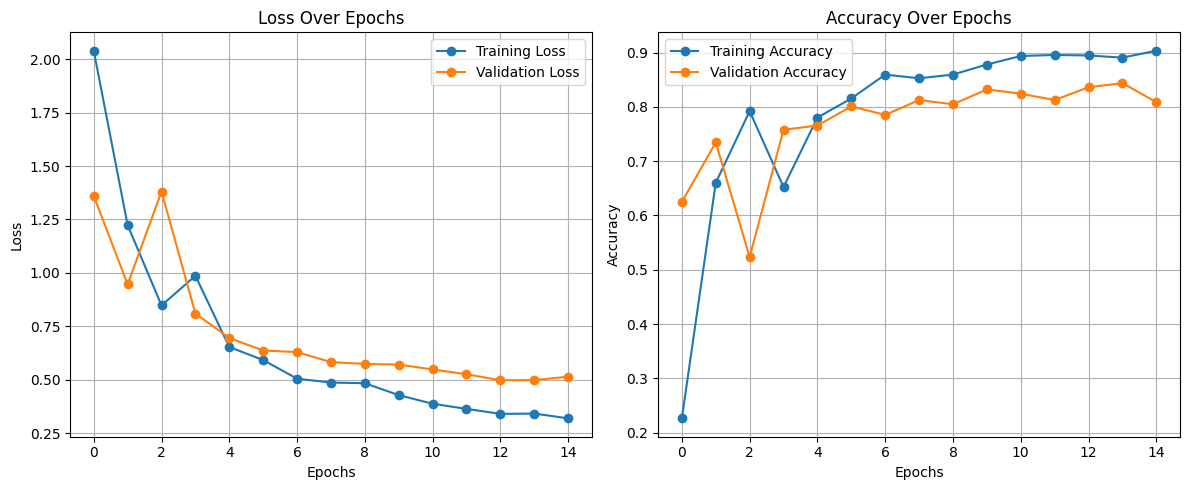

In [ ]:
import matplotlib.pyplot as plt

# history 객체에서 훈련과 검증의 손실 및 정확도 추출
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 1. 손실 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 2. 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# 테스트1.5
input_shape = (max_sentences, embedding_dim)
model = build_lstm_model(input_shape, num_classes)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 모델 요약
model.summary()
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=20
)


# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 88, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         918,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 920,584 (3.51 MB)

 Trainable params: 920,584 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5173 - loss: 1.3725 - val_accuracy: 0.7617 - val_loss: 0.7207
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8745 - loss: 0.4823 - val_accuracy: 0.8477 - val_loss: 0.5280
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8845 - loss: 0.4107 - val_accuracy: 0.8281 - val_loss: 0.4946
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8993 - loss: 0.2958 - val_accuracy: 0.8594 - val_loss: 0.4674
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9322 - loss: 0.2206 - val_accuracy: 0.8594 - val_loss: 0.4265
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9506 - loss: 0.1712 - val_accuracy: 0.8633 - val_loss: 0.4393
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9691 - loss: 0.1227 - val_accuracy: 0.8359 - val_loss: 0.5703
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9715 - loss: 0.1131 - val_accuracy: 0.8672 - v

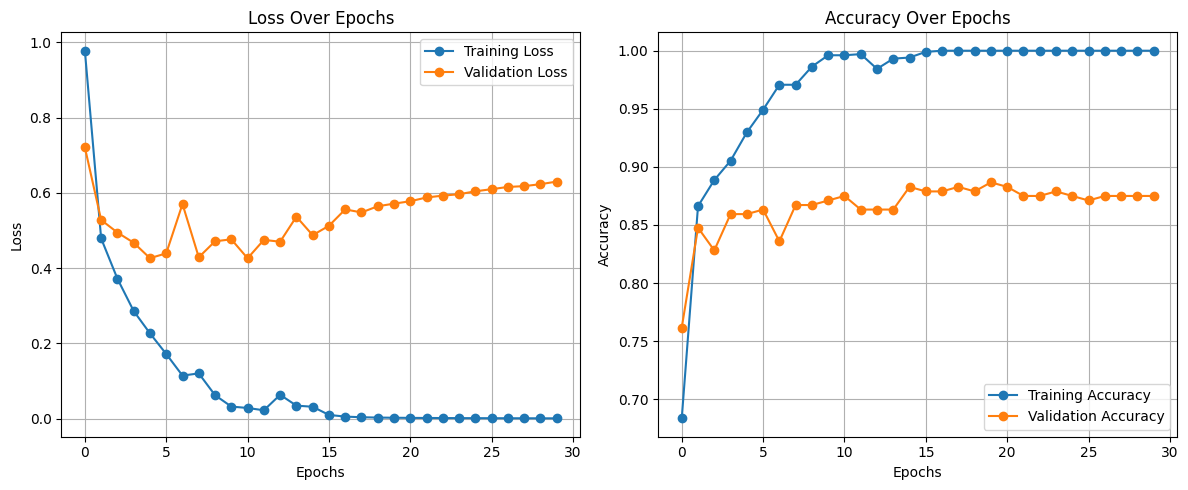

In [ ]:
import matplotlib.pyplot as plt

# history 객체에서 훈련과 검증의 손실 및 정확도 추출
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 1. 손실 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 2. 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# 테스트1.7
input_shape = (max_sentences, embedding_dim)
model = build_lstm_model(input_shape, num_classes)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 모델 요약
model.summary()
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=200
)


# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 88, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 256)                 │         918,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 920,584 (3.51 MB)

 Trainable params: 920,584 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.3589 - loss: 1.8578 - val_accuracy: 0.7188 - val_loss: 1.0916
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7797 - loss: 0.9113 - val_accuracy: 0.8008 - val_loss: 0.7395
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8270 - loss: 0.5753 - val_accuracy: 0.8320 - val_loss: 0.5935
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8621 - loss: 0.4460 - val_accuracy: 0.8242 - val_loss: 0.5441
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9001 - loss: 0.3469 - val_accuracy: 0.8281 - val_loss: 0.5302
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8816 - loss: 0.3485 - val_accuracy: 0.8477 - val_loss: 0.4879
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9194 - loss: 0.2670 - val_accuracy: 0.8359 - val_loss: 0.4790
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9407 - loss: 0.2274 - val_accuracy: 0.8633 - val_loss: 0.4487

In [ ]:
#테스트2
input_shape = (max_sentences, embedding_dim)
model = build_lstm_model(input_shape, num_classes)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 모델 요약
model.summary()
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=50
)

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 88, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 256)                 │         918,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 920,584 (3.51 MB)

 Trainable params: 920,584 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4944 - loss: 1.4933 - val_accuracy: 0.8281 - val_loss: 0.6389
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8521 - loss: 0.4990 - val_accuracy: 0.8125 - val_loss: 0.5500
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8743 - loss: 0.3892 - val_accuracy: 0.8516 - val_loss: 0.5277
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9161 - loss: 0.2850 - val_accuracy: 0.8398 - val_loss: 0.4811
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9313 - loss: 0.2338 - val_accuracy: 0.8555 - val_loss: 0.4637
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9493 - loss: 0.1902 - val_accuracy: 0.8672 - val_loss: 0.4559
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9555 - loss: 0.1289 - val_accuracy: 0.8828 - val_loss: 0.3974
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9829 - loss: 0.1004 - val_accuracy: 0.8750 - v

In [ ]:
#테스트3
input_shape = (max_sentences, embedding_dim)
model = build_lstm_model(input_shape, num_classes)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 모델 요약
model.summary()
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=100
)

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 88, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 256)                 │         918,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 920,584 (3.51 MB)

 Trainable params: 920,584 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.4300 - loss: 1.6888 - val_accuracy: 0.7383 - val_loss: 0.8435
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8152 - loss: 0.6273 - val_accuracy: 0.8008 - val_loss: 0.6613
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8600 - loss: 0.4332 - val_accuracy: 0.8242 - val_loss: 0.6134
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8752 - loss: 0.3636 - val_accuracy: 0.8242 - val_loss: 0.4808
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9174 - loss: 0.2831 - val_accuracy: 0.8516 - val_loss: 0.4596
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9334 - loss: 0.2334 - val_accuracy: 0.8398 - val_loss: 0.4628
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9508 - loss: 0.1788 - val_accuracy: 0.8555 - val_loss: 0.4185
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9506 - loss: 0.1539 - val_accuracy: 0.8594 - 

In [ ]:
#테스트4
input_shape = (max_sentences, embedding_dim)
model = build_lstm_model(input_shape, num_classes)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 모델 요약
model.summary()
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=10
)

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 88, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 256)                 │         918,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 920,584 (3.51 MB)

 Trainable params: 920,584 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5749 - loss: 1.2808 - val_accuracy: 0.7852 - val_loss: 0.6851
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8358 - loss: 0.4859 - val_accuracy: 0.8359 - val_loss: 0.5178
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8755 - loss: 0.4298 - val_accuracy: 0.8008 - val_loss: 0.6158
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9051 - loss: 0.3338 - val_accuracy: 0.8594 - val_loss: 0.4298
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9418 - loss: 0.2281 - val_accuracy: 0.8594 - val_loss: 0.4480
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9353 - loss: 0.2111 - val_accuracy: 0.8438 - val_loss: 0.4307
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9524 - loss: 0.1870 - val_accuracy: 0.8398 - val_loss: 0.4849
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9712 - loss: 0.1058 - val_accu

# **모델 2**

In [ ]:
# LSTM 노드 수 128->256
# 모델 정의
def build_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape, name="input_layer")

    # Bidirectional LSTM
    lstm_out = Bidirectional(LSTM(256, return_sequences=False))(inputs)

    # Fully Connected Layer
    outputs = Dense(num_classes, activation="softmax", name="output_layer")(lstm_out)

    model = Model(inputs=inputs, outputs=outputs, name="LSTM_Classifier")
    return model


In [ ]:
#테스트1
input_shape = (max_sentences, embedding_dim)
model = build_lstm_model(input_shape, num_classes)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 모델 요약
model.summary()
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=20
)

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 88, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 512)                 │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,103,304 (8.02 MB)

 Trainable params: 2,103,304 (8.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5849 - loss: 1.2289 - val_accuracy: 0.8164 - val_loss: 0.5999
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8356 - loss: 0.4885 - val_accuracy: 0.8203 - val_loss: 0.5926
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8908 - loss: 0.3586 - val_accuracy: 0.8555 - val_loss: 0.4251
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9167 - loss: 0.2674 - val_accuracy: 0.8242 - val_loss: 0.5902
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9158 - loss: 0.2527 - val_accuracy: 0.8477 - val_loss: 0.4550
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9307 - loss: 0.2181 - val_accuracy: 0.8516 - val_loss: 0.5033
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9597 - loss: 0.1344 - val_accuracy: 0.8477 - val_loss: 0.5064
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9733 - loss: 0.0936 - val_accuracy: 0.8555 - v

# **모델 3**

In [ ]:
#모델 3 : 레이어 추가


def build_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape, name="input_layer")

    # Bidirectional LSTM
    x = Bidirectional(LSTM(256, return_sequences=True))(inputs)
    lstm_out = Bidirectional(LSTM(128, return_sequences=False))(x)

    # Fully Connected Layer
    outputs = Dense(num_classes, activation="softmax", name="output_layer")(lstm_out)

    model = Model(inputs=inputs, outputs=outputs, name="LSTM_Classifier")
    return model


In [ ]:
#테스트1
input_shape = (max_sentences, embedding_dim)
model = build_lstm_model(input_shape, num_classes)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 모델 요약
model.summary()
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=20
)

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 88, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 88, 512)             │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 256)                 │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,757,640 (10.52 MB)

 Trainable params: 2,757,640 (10.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.5880 - loss: 1.2442 - val_accuracy: 0.7578 - val_loss: 0.7080
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8153 - loss: 0.5500 - val_accuracy: 0.8164 - val_loss: 0.6196
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8573 - loss: 0.4033 - val_accuracy: 0.7930 - val_loss: 0.6915
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8667 - loss: 0.3830 - val_accuracy: 0.8320 - val_loss: 0.6042
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8760 - loss: 0.3551 - val_accuracy: 0.8398 - val_loss: 0.4968
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9075 - loss: 0.2606 - val_accuracy: 0.8320 - val_loss: 0.5090
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9561 - loss: 0.1530 - val_accuracy: 0.8281 - val_loss: 0.6054
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9301 - loss: 0.1993 - val_accuracy: 0.8555 - v

# **모델 4**

In [ ]:
#모델 4 : 모델 3을 봤을 때 레이어 추가는 효과가 없고, 노드 수를 128 -> 256으로 했을 때 정확도가 올랐다. 따라서 모델3에서 레이어를 제거하고 노드 수를 256 -> 512


def build_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape, name="input_layer")

    # Bidirectional LSTM
    lstm_out = Bidirectional(LSTM(512, return_sequences=False))(inputs)

    # Fully Connected Layer
    outputs = Dense(num_classes, activation="softmax", name="output_layer")(lstm_out)

    model = Model(inputs=inputs, outputs=outputs, name="LSTM_Classifier")
    return model


In [ ]:
#테스트1
input_shape = (max_sentences, embedding_dim)
model = build_lstm_model(input_shape, num_classes)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 모델 요약
model.summary()
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=20
)

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 88, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 1024)                │       5,246,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           8,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,255,176 (20.05 MB)

 Trainable params: 5,255,176 (20.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5895 - loss: 1.1792 - val_accuracy: 0.8320 - val_loss: 0.5423
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8655 - loss: 0.4013 - val_accuracy: 0.8203 - val_loss: 0.5666
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8551 - loss: 0.4094 - val_accuracy: 0.7891 - val_loss: 0.5789
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9226 - loss: 0.2594 - val_accuracy: 0.8633 - val_loss: 0.4750
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9319 - loss: 0.2279 - val_accuracy: 0.8320 - val_loss: 0.5315
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9239 - loss: 0.2270 - val_accuracy: 0.8477 - val_loss: 0.4733
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9711 - loss: 0.1148 - val_accuracy: 0.8555 - val_loss: 0.4652
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9783 - loss: 0.0843 - val_accuracy: 0.8555 - v

In [ ]:
#테스트2
input_shape = (max_sentences, embedding_dim)
model = build_lstm_model(input_shape, num_classes)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 모델 요약
model.summary()
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=5
)

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 88, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 1024)                │       5,246,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           8,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,255,176 (20.05 MB)

 Trainable params: 5,255,176 (20.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5753 - loss: 1.2998 - val_accuracy: 0.7773 - val_loss: 0.7296
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.8379 - loss: 0.5200 - val_accuracy: 0.8164 - val_loss: 0.6099
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.8789 - loss: 0.3756 - val_accuracy: 0.7812 - val_loss: 0.5662
Epoch 4/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9066 - loss: 0.3002 - val_accuracy: 0.8320 - val_loss: 0.4692
Epoch 5/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9231 - loss: 0.2152 - val_accuracy: 0.8164 - val_loss: 0.5438
Epoch 6/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9416 - loss: 0.1700 - val_accuracy: 0.8203 - val_loss: 0.6082
Epoch 7/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9608 - loss: 0.1352 - val_accuracy: 0.8359 - val_loss: 0.5419
Epoch 8/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9712 - loss: 0.0946 - val_a

# **모델 5**

In [ ]:
#모델 5 : 드롭아웃 추가

def build_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape, name="input_layer")

    # Bidirectional LSTM
    lstm_out = Bidirectional(LSTM(512, dropout = 0.3, return_sequences=False))(inputs)

    # Fully Connected Layer
    outputs = Dense(num_classes, activation="softmax", name="output_layer")(lstm_out)

    model = Model(inputs=inputs, outputs=outputs, name="LSTM_Classifier")
    return model


In [ ]:
#테스트1
input_shape = (max_sentences, embedding_dim)
model = build_lstm_model(input_shape, num_classes)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 모델 요약
model.summary()
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=20
)

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 88, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 1024)                │       5,246,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           8,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,255,176 (20.05 MB)

 Trainable params: 5,255,176 (20.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5399 - loss: 1.2623 - val_accuracy: 0.7344 - val_loss: 0.8281
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8095 - loss: 0.6039 - val_accuracy: 0.7969 - val_loss: 0.5421
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8585 - loss: 0.3786 - val_accuracy: 0.8359 - val_loss: 0.4966
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8851 - loss: 0.3311 - val_accuracy: 0.7891 - val_loss: 0.6338
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8963 - loss: 0.3343 - val_accuracy: 0.8086 - val_loss: 0.5654
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9039 - loss: 0.2780 - val_accuracy: 0.8516 - val_loss: 0.4300
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9296 - loss: 0.2336 - val_accuracy: 0.8320 - val_loss: 0.5468
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9409 - loss: 0.1902 - val_accuracy: 0.8320 - v

In [ ]:
#테스트2
input_shape = (max_sentences, embedding_dim)
model = build_lstm_model(input_shape, num_classes)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 모델 요약
model.summary()
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=10
)

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 88, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ (None, 1024)                │       5,246,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           8,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,255,176 (20.05 MB)

 Trainable params: 5,255,176 (20.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5609 - loss: 1.2340 - val_accuracy: 0.7617 - val_loss: 0.6094
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8335 - loss: 0.4924 - val_accuracy: 0.7773 - val_loss: 0.6252
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8587 - loss: 0.4287 - val_accuracy: 0.8281 - val_loss: 0.5019
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8854 - loss: 0.3512 - val_accuracy: 0.8438 - val_loss: 0.4908
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9032 - loss: 0.3021 - val_accuracy: 0.8516 - val_loss: 0.4607
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9162 - loss: 0.2576 - val_accuracy: 0.8438 - val_loss: 0.4669
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9209 - loss: 0.2245 - val_accuracy: 0.8203 - val_loss: 0.6522
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9304 - loss: 0.2037 - val_accu

In [ ]:
#모델 6 : 512 -> 256

def build_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape, name="input_layer")

    # Bidirectional LSTM
    lstm_out = Bidirectional(LSTM(256, dropout = 0.3, return_sequences=False))(inputs)

    # Fully Connected Layer
    outputs = Dense(num_classes, activation="softmax", name="output_layer")(lstm_out)

    model = Model(inputs=inputs, outputs=outputs, name="LSTM_Classifier")
    return model


In [ ]:
#테스트1
input_shape = (max_sentences, embedding_dim)
model = build_lstm_model(input_shape, num_classes)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 모델 요약
model.summary()
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=20
)

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 88, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ (None, 512)                 │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,103,304 (8.02 MB)

 Trainable params: 2,103,304 (8.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5011 - loss: 1.3709 - val_accuracy: 0.7617 - val_loss: 0.7240
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8291 - loss: 0.5356 - val_accuracy: 0.8242 - val_loss: 0.5689
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8656 - loss: 0.3892 - val_accuracy: 0.8438 - val_loss: 0.4695
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9104 - loss: 0.3027 - val_accuracy: 0.8164 - val_loss: 0.5763
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9180 - loss: 0.2791 - val_accuracy: 0.7969 - val_loss: 0.5675
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9032 - loss: 0.2941 - val_accuracy: 0.8203 - val_loss: 0.5651
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9500 - loss: 0.1690 - val_accuracy: 0.8555 - val_loss: 0.4454
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9366 - loss: 0.2024 - val_accuracy: 0.8477 - v

In [ ]:
#테스트2
input_shape = (max_sentences, embedding_dim)
model = build_lstm_model(input_shape, num_classes)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 모델 요약
model.summary()
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=10
)

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 88, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_14 (Bidirectional)     │ (None, 512)                 │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,103,304 (8.02 MB)

 Trainable params: 2,103,304 (8.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5451 - loss: 1.2956 - val_accuracy: 0.7383 - val_loss: 0.7549
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8335 - loss: 0.5146 - val_accuracy: 0.8125 - val_loss: 0.6172
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8772 - loss: 0.4156 - val_accuracy: 0.8320 - val_loss: 0.5269
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8794 - loss: 0.3359 - val_accuracy: 0.8203 - val_loss: 0.5664
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9026 - loss: 0.3155 - val_accuracy: 0.8320 - val_loss: 0.4676
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9313 - loss: 0.2231 - val_accuracy: 0.8008 - val_loss: 0.5449
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9311 - loss: 0.2137 - val_accuracy: 0.8047 - val_loss: 0.5316
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9219 - loss: 0.2408 - val_accu

In [ ]:
# 시연 영상 코드

import numpy as np
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional
import tkinter as tk

# LSTM모델 정의
def build_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape, name="input_layer")

    # Bidirectional LSTM
    # 첫 번째 Bidirectional LSTM
    lstm_out = Bidirectional(LSTM(256, return_sequences=False))(inputs)

    # Fully Connected Layer
    outputs = Dense(num_classes, activation="softmax", name="output_layer")(lstm_out)

    model = Model(inputs=inputs, outputs=outputs, name="LSTM_Classifier")
    return model

# 모델과 토크나이저 불러오기
tokenizer = BertTokenizer.from_pretrained("klue/bert-base")
bert_model = TFBertModel.from_pretrained("klue/bert-base")



# 입력 텍스트를 BERT 토큰화 및 예측
def predict_category():
    input_text = text_entry.get("1.0", tk.END).strip()
    if not input_text:
        messagebox.showerror("Error", "텍스트를 입력하세요!")
        return

    input_texts = input_text.split(".")
    inputs = tokenizer(
        input_texts,
        max_length=256,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # BERT로 CLS 토큰 추출

    outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    cls_token = outputs.last_hidden_state[:, 0, :]
    sequencelen = cls_token.shape[0]
    # CLS 토큰 크기 조정
    cls_token = tf.expand_dims(cls_token, axis=1)
    cls_token = tf.tile(cls_token, [1, sequencelen, 1]) 

    # 모델 생성
    input_shape = (sequencelen, 768) 
    model = build_lstm_model(input_shape, 8)

    # 가중치 불러오기
    model.load_weights("./NCC_LSTM.h5")

    # 모델로 예측
    prediction = model.predict(cls_token)
    predicted_label = tf.argmax(prediction, axis=1).numpy()[0]
    label_list = ["정치","경제","사회","생활/문화","세계","기술/IT","연예","스포츠"]

    # 결과 출력
    result_label.config(
        text=f"예측 결과: {max(prediction[0])*100:.2f}% 확률로 '{label_list[predicted_label]}' 분야입니다."
    )

# === 메인 창 ===
root = tk.Tk()
root.title("뉴스 기사 카테고리 분류")

# 입력 텍스트 영역
tk.Label(root, text="기사 입력:", font=("Arial", 14)).pack(pady=10)
text_entry = tk.Text(root, height=10, width=50)
text_entry.pack(pady=10)

# 예측 버튼
predict_button = tk.Button(root, text="예측하기", command=predict_category, font=("Arial", 12))
predict_button.pack(pady=5)

# 결과 출력 영역
result_label = tk.Label(root, text="예측 결과:", font=("Arial", 14))
result_label.pack(pady=10)

# GUI 실행
root.mainloop()